# Solution 3.3 - Regularized Regression

## DRW & UofC Quant Foundations
### Summer 2024
#### Mark Hendricks
#### hendricks@uchicago.edu

***

# Penalized Regression

$$\newcommand{\nsecs}{450}$$
$$\newcommand{\target}{GLD}$$
$$\newcommand{\spy}{\text{spy}}$$
$$\newcommand{\hyg}{\text{hyg}}$$

## Data
* This homework uses the file, `data/spx_weekly_returns_single_names.xlsx`.
* Find the data in the Github repo associated with the module, (link on Canvas.)

The data file contains...
* Return rates, $r^{\target}_t$, for the \target, (an ETF,) which tracks the returns on gold.
* Return rates, $r^i_t$, for $\nsecs$ single-name equities. 

#### Note
These are less than 500 return series in the sample due to filtering out securities with insufficient return histories.

## Model
Consider a regression of $\target$, denoted $r^{\target}$, on all $\nsecs$ returns of the S&P 500 stocks.

$$
r^{\target}_t = \alpha + \sum_{j=1}^k \beta^j r^j_t + \epsilon_t
\label{eq:REG}
$$

We refer to this equation below as the `MODEL`.

***

# 1. 

Estimate the `MODEL` with OLS.

#### Note
For this OLS estimation, along with the estimations below, try using scikit-learn in Python

`from sklearn import LinearRegression Lasso Ridge`

For OLS specifically, try

`model_ols = LinearRegression().fit(X,y)`

### 1.1. 
Report the R-squared.
### 1.2. 
Which factors have the largest betas in explaining $r^{\target}$?
### 1.3. 
Calculate $\beta^j \sigma^j$ for each regressor. Which of these is largest in magnitude, and thus most influential in explaining $r^{\target}$?

#### Note
The beta being large may simply be because the regressor volatility is small. By scaling by the volatility, we get a better idea of which regressor is driving the most variation.

### 1.4. 
Report the matrix condition number of $R'R$, where $R$ denotes the matrix of single-name equity return data. Why should this condition number give us pause about trusting the OLS estimates out-of-sample?

#### Note
To get the matrix condition number, consider using, in Python, `numpy.linalg.cond()`.

#  2. 

Estimate `MODEL` with Ridge Regression. 
* Use a penalty of `ALPHA=0.5` in the estimation.
* Try using `est = Ridge(alpha=ALPHA).fit(X,y)`

### 2.1.
Report the R-squared.
### 2.2.
Based on $\beta^j \sigma^j$, which factor is most influential for $r^{\target}$?

### 2.3.
Report the matrix condition number of the $R'R$.

### 2.4.
How many regressors have a non-zero beta estimates? 

***

# 3. 

Estimate `MODEL` with LASSO Regression. 
* Use a penalty of `ALPHA=7e-5` in the estimation.
* Try using `est = Lasso(alpha=ALPHA).fit(X,y)`

### 3.1.
Report the R-squared.

### 3.2.
Based on $\beta^j \sigma^j$, which factor is most influential for $r^{\target}$?

### 3.3.
Report the matrix condition number of the $R'R$.

### 3.4.
How many regressors have a non-zero beta estimates? 

***

# 4.

How do the estimations compare across the three methods?

### 4.1.
Create a histogram of estimated betas across the three methods, (OLS, Ridge, LASSO.) 

Are they all nonzero? Are there positive and negative values? Do they range widely in magnitude? 

### 4.2.
Which has the largest R-squared? Is this a surprise?

***

# 5.

Try using cross-validation (with K-folds) to estimate the penalty parameter for Ridge and LASSO.

Estimate this CV using two functions from  `sklearn.linear_model`
* RidgeCV
* LassoCV

Feel free to use the default parameters, including the default number of folds.

Report the CV penalty parameter for Lasso and Ridge.

***

# 6.

Use your estimations based on data through 2022 to fit the model for 2023-2024. Use the CV penalty parameters (from the previous problem) for Ridge and Lasso.

* What is the r-squared in these out-of-sample fits?


#### Note
Doing this is really easy in Python. For instance, for the LASSO estimation, you could try

`est = Lasso(alpha=ALPHA).fit(X,y)`

`score_is = est.score(X_insamp,y_insamp)`

`score_oos = est.score(X_oos,y_oos)`

Which method does better out-of-sample?

***

# <span style='color:red'>Solutions 1, 2, 3</span>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
FILEIN = '../data/spx_weekly_returns_single_names.xlsx'
rets_sp500 = pd.read_excel(FILEIN, sheet_name=2, index_col=0)
rets_gld = pd.read_excel(FILEIN, sheet_name=3, index_col=0)[['GLD']]

NSECS = rets_sp500.shape[1]

## <span style='color:red'>OLS</span>

In [3]:
ols_model = sm.OLS(rets_gld, sm.add_constant(rets_sp500)).fit()
coef_ols = ols_model.params[1:].to_frame('Beta')

In [4]:
sigma_beta_ols = rets_sp500.std() * coef_ols['Beta']

## <span style='color:red'>Ridge</span>

In [5]:
ALPHA_RIDGE = 0.5
model_Ridge = Ridge(alpha=ALPHA_RIDGE, fit_intercept=True).fit(rets_sp500, rets_gld)
coef_ridge = pd.DataFrame(data=model_Ridge.coef_.reshape(NSECS), index=rets_sp500.columns, columns=['Beta'])

sigma_beta_ridge = rets_sp500.std() * coef_ridge['Beta']
scaled_betas = sigma_beta_ridge.loc[lambda x: x.abs().nlargest(5).index]

## <span style='color:red'>LASSO</span>

In [6]:
ALPHA = 7e-5
model_Lasso = Lasso(alpha=ALPHA, fit_intercept=True).fit(rets_sp500, rets_gld)
coef_lasso = pd.DataFrame(data=model_Lasso.coef_.reshape(NSECS), index=rets_sp500.columns, columns=['Beta'])

sigma_beta_lasso = rets_sp500.std() * coef_lasso['Beta']

***

# <span style='color:red'>Tables for Solutions 1, 2, 3.</span>

### <span style='color:red'>R-squared (in-sample)</span>

In [7]:
rsq = pd.DataFrame([ols_model.rsquared, model_Ridge.score(rets_sp500, rets_gld), model_Lasso.score(rets_sp500, rets_gld)],columns=['r-squared (in-sample)'],index=['ols','ridge','lasso'])
rsq.style.format('{:.1%}')

### <span style='color:red'>Ranking Betas by Nominal Size</span>

In [8]:
def get_top_values_and_indices(column, n=5):
    top_values = column.nlargest(n)
    return top_values.index, top_values.values

In [9]:
df = pd.concat([coef_ols,coef_ridge,coef_lasso],axis=1)
df.columns = ['ols','ridge','lasso']

In [10]:
# Create an empty dictionary to store the new DataFrame
new_data = {}
n = 5

# Populate the new_data dictionary
for col in df.columns:
    indices, values = get_top_values_and_indices(df[col], n)
    new_data[f'{col} index'] = indices
    new_data[f'{col} beta'] = values

# Create a new DataFrame from the new_data dictionary
top_df = pd.DataFrame(new_data)
top_df.index = [f'#{i+1}' for i in range(n)]

# Display the DataFrame
format_dict = {col: '{:.1%}' for col in top_df.columns if col.endswith('beta')}

# Apply the formatting to the DataFrame
top_df.style.format(format_dict)

### <span style='color:red'>Ranking Betas by Vol-Scaled Size</span>

In [11]:
df = pd.concat([sigma_beta_ols, sigma_beta_ridge, sigma_beta_lasso],axis=1)
df.columns = ['ols','ridge','lasso']

In [12]:
# Create an empty dictionary to store the new DataFrame
new_data = {}
n = 5

# Populate the new_data dictionary
for col in df.columns:
    indices, values = get_top_values_and_indices(df[col], n)
    new_data[f'{col} index'] = indices
    new_data[f'{col} scaled beta'] = values

# Create a new DataFrame from the new_data dictionary
top_df = pd.DataFrame(new_data)
top_df.index = [f'#{i+1}' for i in range(n)]

# Display the DataFrame
format_dict = {col: '{:.2%}' for col in top_df.columns if col.endswith('beta')}

# Apply the formatting to the DataFrame
top_df.style.format(format_dict)

Scaling by $\sigma_j$ allows us to have a more useful comparison between regression coefficients. In doing so, we find the largest (in magnitude) of the coefficients, and thus the most influential regressor, is NEM. 

### <span style='color:red'>Condition Number of $R'R$</span>

In [13]:
Xols = rets_sp500.T@rets_sp500
Xridge = rets_sp500.T@rets_sp500 + np.diag(np.ones(rets_sp500.shape[1])) * ALPHA_RIDGE
idx_lasso = rets_sp500.columns[(coef_lasso != 0)['Beta']]
Xlasso = rets_sp500[idx_lasso].T@rets_sp500[idx_lasso]

condition_numbers = pd.DataFrame(columns=['matrix condition'],
                              index=['OLS','Ridge','LASSO'],
                              data=[np.linalg.cond(Xols),                                     
                                    np.linalg.cond(Xridge),
                                    np.linalg.cond(Xlasso)
                                   ])

#condition_numbers['number of regressors'] = [(coef_ols != 0).sum()[0], (coef_ridge != 0).sum()[0], (coef_lasso != 0).sum()[0]] #[X.shape[1], X.shape[1], Xlasso.shape[1]]

condition_numbers.style.format('{:,.0f}')

A large condition number should give us pause as it indicates that very small change in the inputs to our training data would yield very large changes in our model's fitted parameters. In the case of linear regression, a high condition number raises concerns about multicollinearity, which can easily distort both the interpretation of coefficients and their out-of-sample performance. The condition numbers produced here are extremely large.

### <span style='color:red'>Selected Regressors</span>

In [14]:
pd.DataFrame([(coef_ols != 0).sum()[0], (coef_ridge != 0).sum()[0], (coef_lasso != 0).sum()[0]],index=['ols','ridge','lasso'],columns=['nonzero betas'])

/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_18731/3216195697.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame([(coef_ols != 0).sum()[0], (coef_ridge != 0).sum()[0], (coef_lasso != 0).sum()[0]],index=['ols','ridge','lasso'],columns=['nonzero betas'])


nonzero betas
ols              446
ridge            446
lasso             11

# <span style='color:red'>Solution 4</span>

## <span style='color:red'>4.1.</span>

<Axes: title={'center': 'OLS Coefficients'}, ylabel='Frequency'>

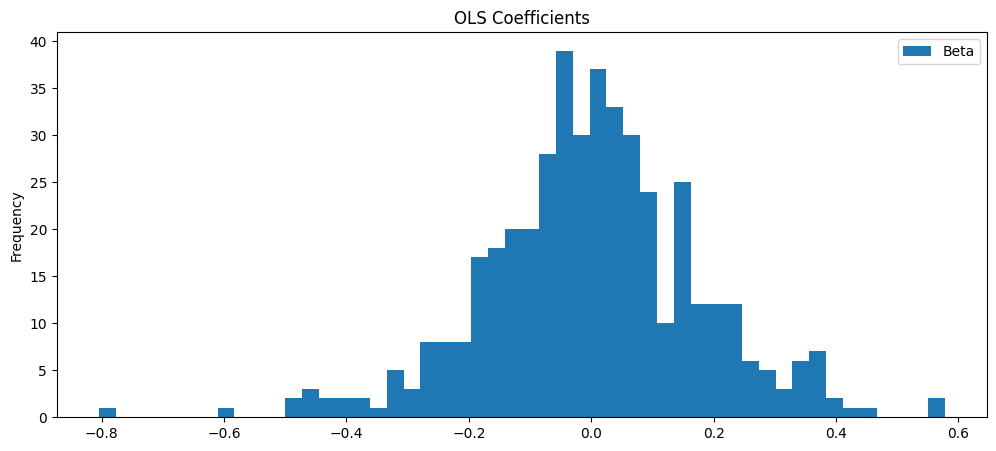

In [15]:
coef_ols.plot(kind='hist', bins=50, figsize=(12, 5), title='OLS Coefficients')

<Axes: title={'center': 'Ridge Coefficients'}, ylabel='Frequency'>

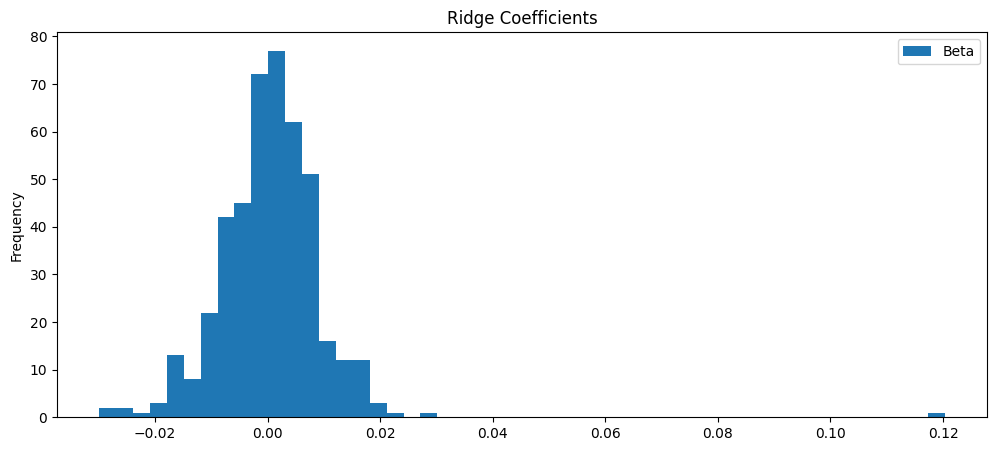

In [16]:
coef_ridge.plot(kind='hist', bins=50, figsize=(12, 5), title='Ridge Coefficients')

<Axes: title={'center': 'Lasso Coefficients'}, ylabel='Frequency'>

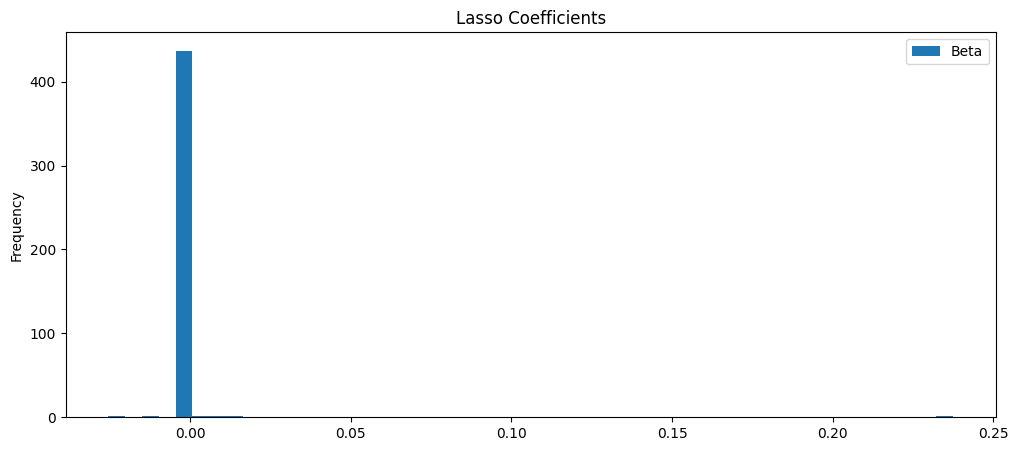

In [17]:
coef_lasso.plot(kind='hist', bins=50, figsize=(12, 5), title='Lasso Coefficients')

Immediately, it is quite clear that the penalized regressions (Lasso and Ridge) have notably smaller coefficients in general. It is also clear that the penalized regressions tend to push many coefficients towards 0, but some get pushed away from 0. This reflects the notion that the penalties serve to give more "responsibility" to certain regressors.

Unsurprisingly, all 3 models had coefficients distributed near 0, with Lasso having a significant proportion of them being equal to 0.

## <span style='color:red'>4.2.</span>

From above, we found that OLS had the largest r-squared, which is entirely unsurprising given that this is referring to *in sample* performance. OLS was given far more "power" to fit the training data.

***

# <span style='color:red'>Solution 5</span>

In [18]:
model_ridge_cv = RidgeCV().fit(rets_sp500, np.ravel(rets_gld))

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    model_lasso_cv = LassoCV(max_iter=100).fit(rets_sp500, np.ravel(rets_gld))

In [20]:
pd.DataFrame([model_ridge_cv.alpha_, model_lasso_cv.alpha_], columns=['CV optimal penalty'],index=['ridge','lasso'])

CV optimal penalty
ridge            1.000000
lasso            0.000042

# <span style='color:red'>Solution 6</span>

In [21]:
YEAR_IS = '2022'
YEAR_OOS = '2023'

train_X = rets_sp500.loc[:YEAR_IS]
train_y = rets_gld.loc[:YEAR_IS]

test_X = rets_sp500.loc[YEAR_OOS:]
test_y = rets_gld.loc[YEAR_OOS:]

In [22]:
ols_is = LinearRegression().fit(train_X, train_y)
ridge_is = Ridge(alpha=model_ridge_cv.alpha_).fit(train_X, train_y)
lasso_is = Lasso(alpha=model_lasso_cv.alpha_).fit(train_X, train_y)

In [23]:
oos_rsq = pd.DataFrame([ols_is.score(test_X, test_y),ridge_is.score(test_X, test_y), lasso_is.score(test_X, test_y)],columns=['OOS r-squared'],index=['ols','ridge','lasso'])
oos_rsq.style.format('{:.2%}')

As demonstrated by the out of sample r-squared values, OLS performs far worse than does penalized regression. In fact, both Lasso and Ridge perform far better than the null model. Given more penalty values in our cross-validation for Ridge (instead of the default scikit-learn parameters), we may be better able to compare Lasso and Ridge. In general, however, it is important to remember that the "optimal" penalties found in part 5 were calculated using the test sample, which gives rise to some lookahead bias.